In [161]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import KBinsDiscretizer, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, cross_val_predict
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest, RandomForestClassifier, GradientBoostingClassifier
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.feature_selection import SelectKBest, f_classif, SelectFromModel

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.decomposition import PCA

In [2]:
file_path = "heart.csv"
df = pd.read_csv(file_path)

In [3]:
print("Prvih 5 redova:")
display(df.head())

Prvih 5 redova:


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [4]:
df.shape

(918, 12)

In [5]:
print("\nInfo o datasetu:")
print(df.info())


Info o datasetu:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB
None


In [6]:
unique_counts = {
    col: df[col].nunique()
    for col in df.select_dtypes(include=['object']).columns
}

print(unique_counts)

{'Sex': 2, 'ChestPainType': 4, 'RestingECG': 3, 'ExerciseAngina': 2, 'ST_Slope': 3}


In [7]:
df['HeartDisease'].unique()

array([0, 1], dtype=int64)

In [8]:
df.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [9]:
numeric_df = df.select_dtypes(include=["int64", "float64"])

In [10]:
print("Numeričke kolone:")
num_cols = numeric_df.columns
print(num_cols)

Numeričke kolone:
Index(['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak',
       'HeartDisease'],
      dtype='object')


In [11]:
print("\nStatistika:")
display(numeric_df.describe())


Statistika:


,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


In [12]:

def plot_numeric_distributions(df, num_cols, cols_per_row=4, bins=20, figsize_per_col=4):
    
    num_plots = len(num_cols)
    rows = math.ceil(num_plots / cols_per_row)
    layout_tuple = (rows, cols_per_row)
    figsize = (cols_per_row * figsize_per_col, rows * figsize_per_col)
    
    fig, axes = plt.subplots(rows, cols_per_row, figsize=figsize)
    
    if rows * cols_per_row > 1:
        axes = axes.flatten()
    elif rows == 1 and cols_per_row == 1:
        axes = [axes]
    else:
        axes = axes.ravel()
    
    for i, col in enumerate(num_cols):
        sns.histplot(
            data=df,
            x=col,
            ax=axes[i],
            kde=True,
            bins=bins,
            color='skyblue',
            stat='count'
        )
        
        for line in axes[i].lines:
            if line.get_linestyle() == '-' and line.get_linewidth() > 1:
                line.set_color('red')
                break
        
        axes[i].set_title(f'Distribucija: {col}', fontsize=12)
        axes[i].set_xlabel('')
    
    for i in range(num_plots, len(axes)):
        fig.delaxes(axes[i])
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.suptitle('Histogram distribucije (Seaborn + crvena KDE linija)', fontsize=18, y=0.98)
    plt.show()

plot_numeric_distributions(df, num_cols)

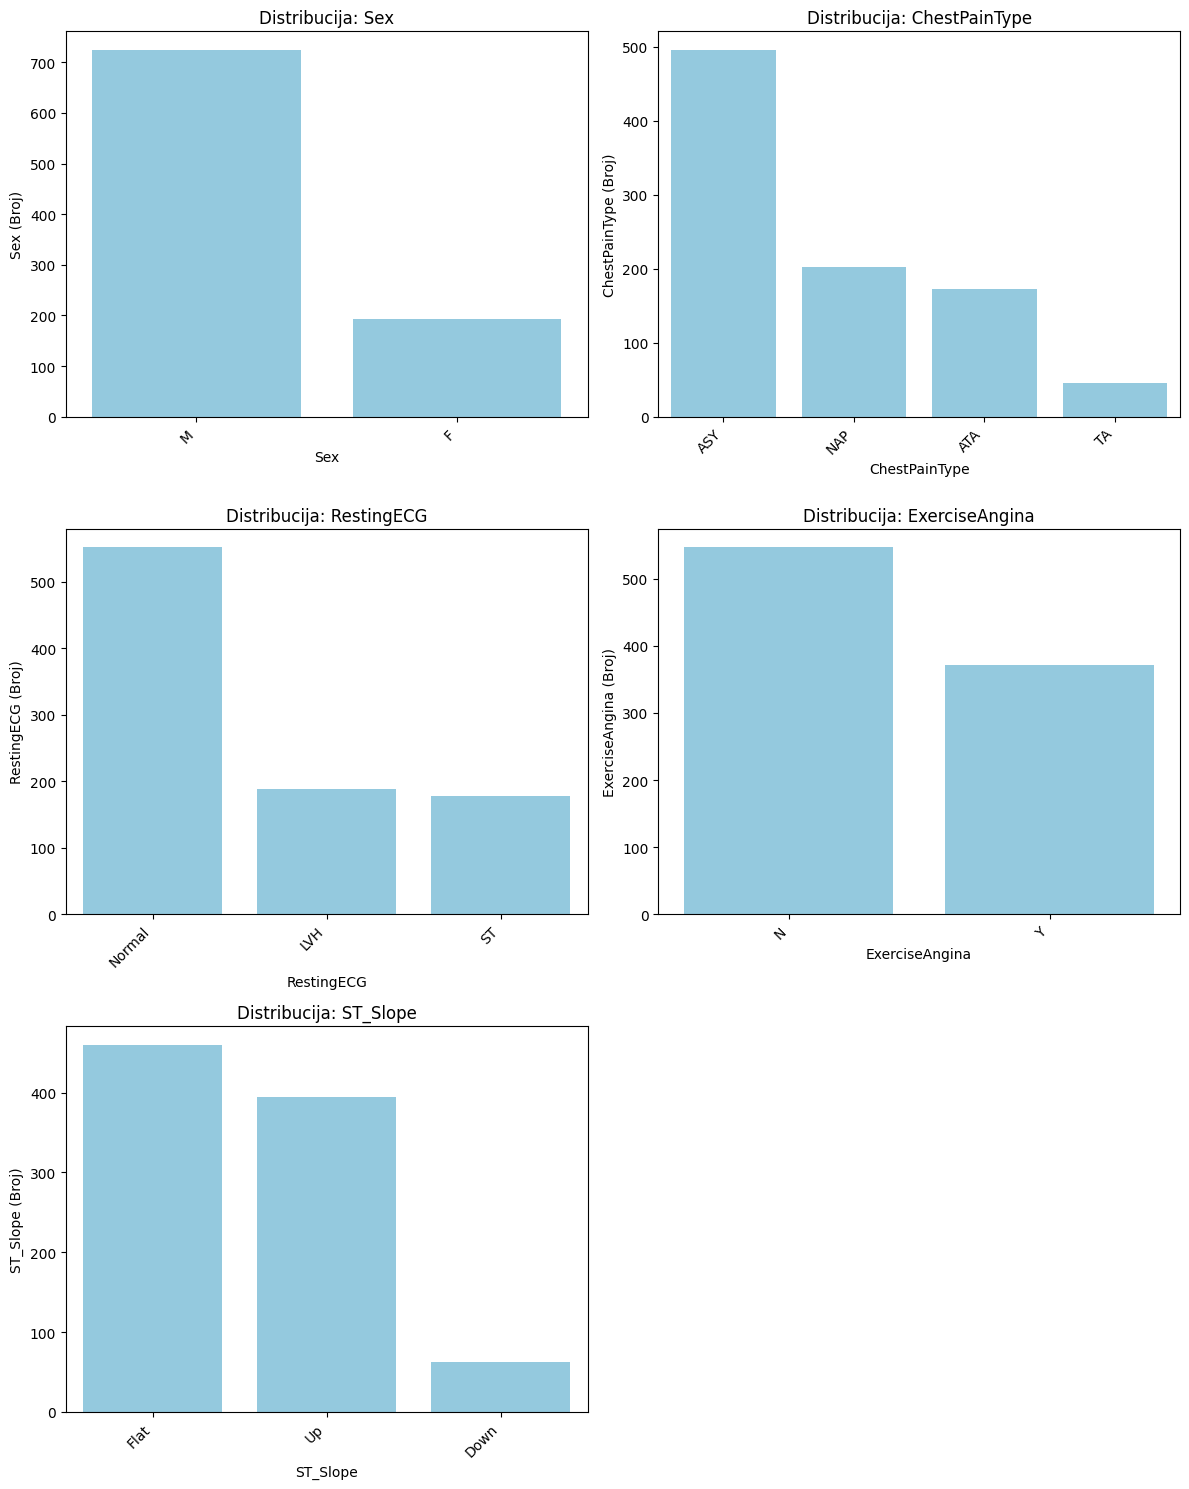

In [14]:
nonnumerical_df = df.select_dtypes(exclude="number")
cols = nonnumerical_df.columns
num_columns = len(cols)

cols_per_row = 2 
rows = (num_columns + cols_per_row - 1) // cols_per_row

plt.figure(figsize=(6 * cols_per_row, 5 * rows)) 

for i, col in enumerate(cols):
    plt.subplot(rows, cols_per_row, i + 1)
    
    sns.countplot(
            data=df,
            x=df[col].astype(str),
            color='skyblue',
            order=df[col].value_counts().index
        )
    
    plt.title(f'Distribucija: {col}')
    plt.xlabel(col)
    plt.ylabel(f'{df[col].name} (Broj)') 
    plt.xticks(rotation=45, ha='right') 

plt.tight_layout() 
plt.show()

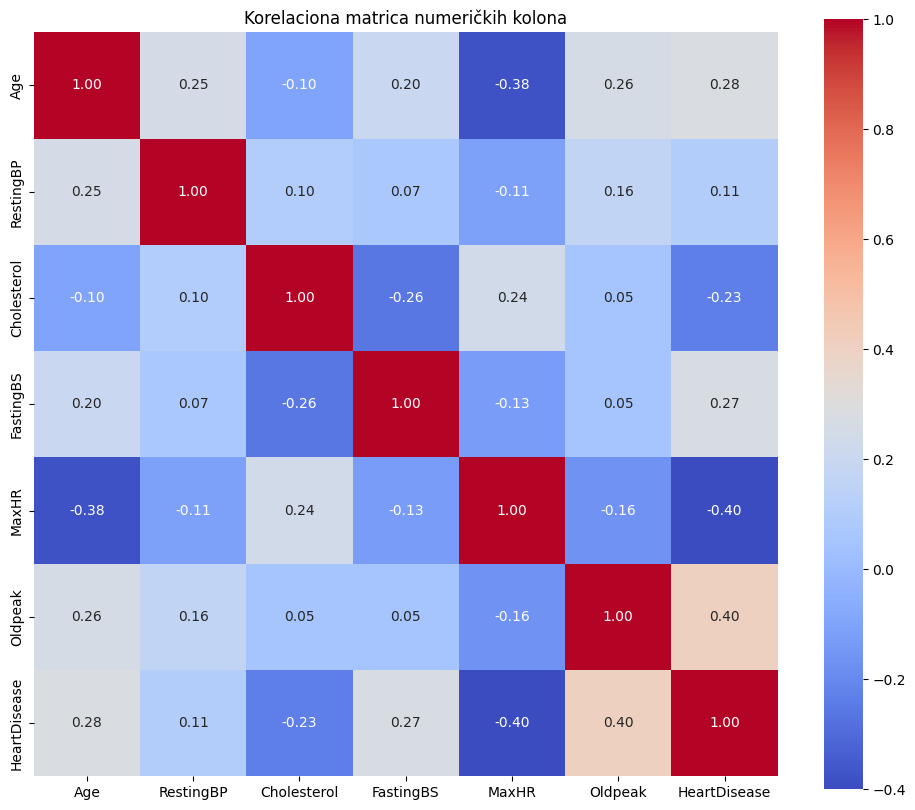

In [15]:
corr_matrix = df[num_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Korelaciona matrica numeričkih kolona")
plt.show()

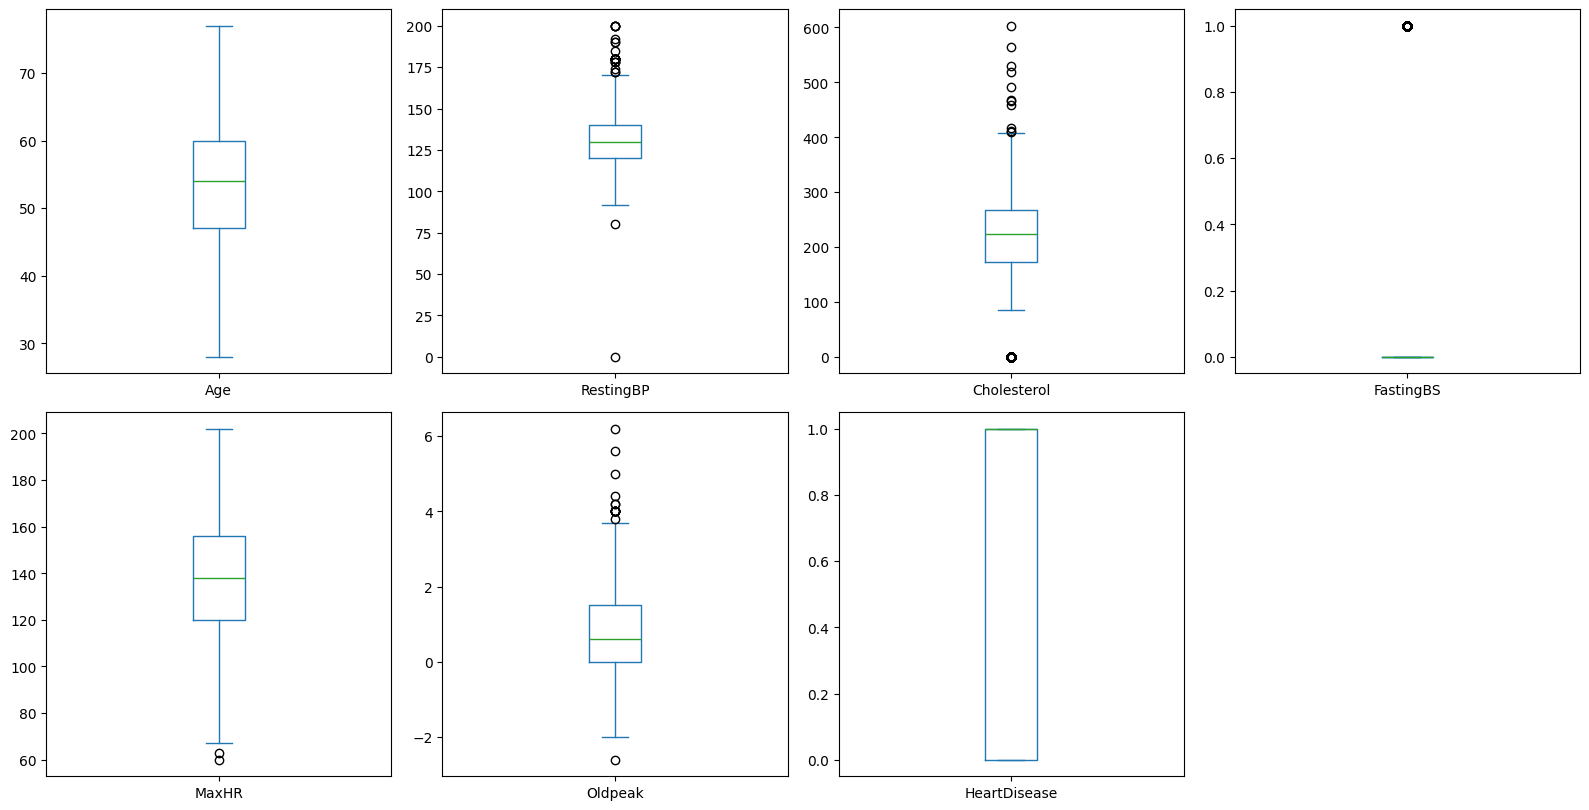

In [16]:
ncols = 4
nrows = int(np.ceil(df.shape[1] / ncols))

df.plot(kind='box', subplots=True, layout=(nrows, ncols), figsize=(16, 4*nrows), sharex=False, sharey=False)
plt.tight_layout()
plt.show()

In [17]:
df_encoded = pd.get_dummies(df, columns=['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope'])

In [18]:
df_encoded.columns

Index(['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak',
       'HeartDisease', 'Sex_F', 'Sex_M', 'ChestPainType_ASY',
       'ChestPainType_ATA', 'ChestPainType_NAP', 'ChestPainType_TA',
       'RestingECG_LVH', 'RestingECG_Normal', 'RestingECG_ST',
       'ExerciseAngina_N', 'ExerciseAngina_Y', 'ST_Slope_Down',
       'ST_Slope_Flat', 'ST_Slope_Up'],
      dtype='object')

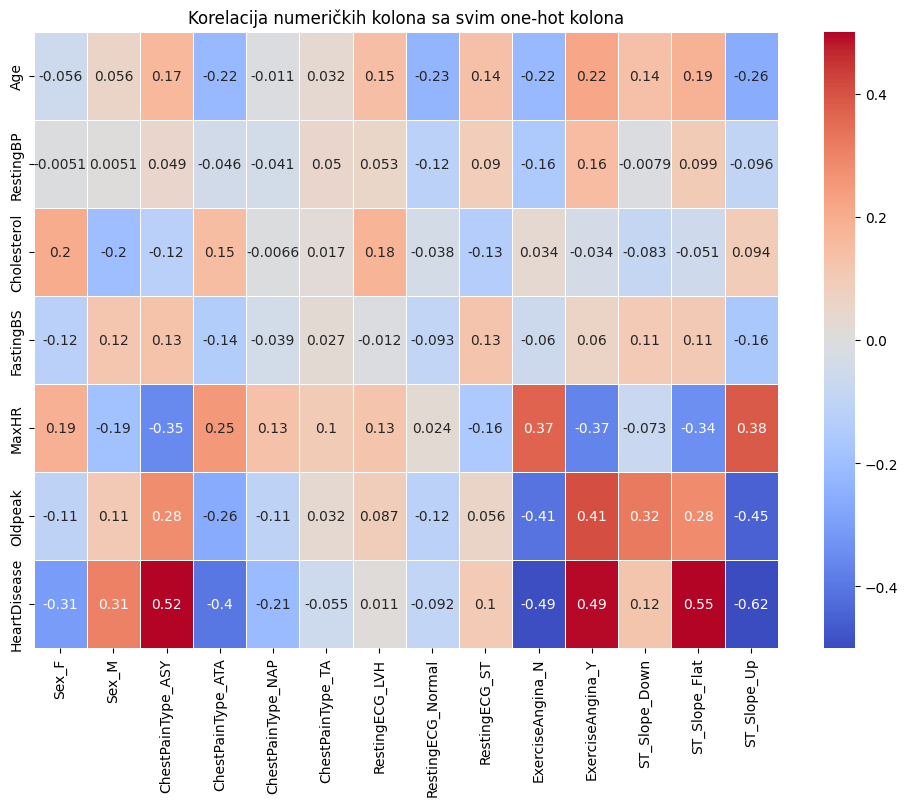

In [19]:
correlation_matrix = df_encoded.corr()

numerical_cols = df_encoded.select_dtypes(include=['number']).columns

one_hot_cols = [col for col in df_encoded.columns if '_' in col and col not in numerical_cols]

corr_subset = correlation_matrix.loc[numerical_cols, one_hot_cols]

plt.figure(figsize=(12, 8))
sns.heatmap(
    corr_subset,
    annot=True,
    cmap='coolwarm',
    center=0,
    vmin=-0.5,
    vmax=0.5,
    linewidths=0.5
)
plt.title('Korelacija numeričkih kolona sa svim one-hot kolona')
plt.show()

In [20]:
def TrainAndReturnSpecs(df):
    X = df.drop('HeartDisease', axis=1)
    y = df['HeartDisease']
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    model = RandomForestClassifier(
        n_estimators=200,
        max_depth=None,
        random_state=42
    )
    
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred,zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    classes = np.unique(y_test)
    if len(classes) == 1:
        roc_auc = 0
    else:
        y_proba = model.predict_proba(X_test)[:,1]
        roc_auc = roc_auc_score(y_test, y_proba)

    res = {
        'accuracy':acc,
        'precision':precision,
        'recall':recall,
        'f1':f1,
        'roc_auc':roc_auc
    }

    return res

In [21]:
ref_dict=dict()
ref_dict['WithNoise']= TrainAndReturnSpecs(df_encoded)

# Binning

In [23]:
def smooth_by_means_per_bin(values, original_values):
    smoothed = np.zeros_like(values, dtype=float)
    for b in np.unique(values):
        mask = values == b
        smoothed[mask] = np.mean(original_values[mask])
    return smoothed

def smooth_by_medians_per_bin(values, original_values):
    smoothed = np.zeros_like(values, dtype=float)
    for b in np.unique(values):
        mask = values == b
        smoothed[mask] = np.median(original_values[mask])
    return smoothed


df_binning = df_encoded.copy()

eq = KBinsDiscretizer(n_bins=30, encode="ordinal", strategy="kmeans")
cols_to_bin = ['Oldpeak', 'Cholesterol', 'RestingBP'] 

eq.fit(df_binning[cols_to_bin])
binned_data = eq.transform(df_binning[cols_to_bin])
df_binned = pd.DataFrame(binned_data, columns=cols_to_bin, index=df_binning.index)
df_binning[cols_to_bin] = df_binned

df_binning['Oldpeak'] = smooth_by_medians_per_bin(df_binning['Oldpeak'].values, df_encoded['Oldpeak'].values)
df_binning['Cholesterol'] = smooth_by_medians_per_bin(df_binning['Cholesterol'].values, df_encoded['Cholesterol'].values)
df_binning['RestingBP'] = smooth_by_means_per_bin(df_binning['RestingBP'].values, df_encoded['RestingBP'].values)

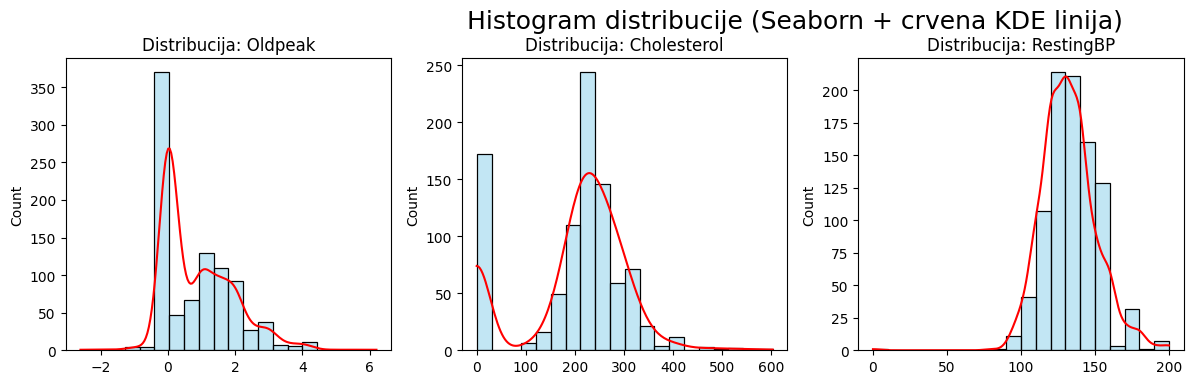

In [24]:
plot_numeric_distributions(df_binning, cols_to_bin)

In [25]:
ref_dict['Binning']= TrainAndReturnSpecs(df_binning)

# Regression


In [27]:
df_reg = df_encoded.copy()

for col in cols_to_bin:
    X_features = df_reg.drop(columns=[col])
    y_target = df_reg[col]

    model = LinearRegression()
    model.fit(X_features, y_target)

    df_reg[col] = model.predict(X_features)

In [28]:
ref_dict['Regression']= TrainAndReturnSpecs(df_reg)

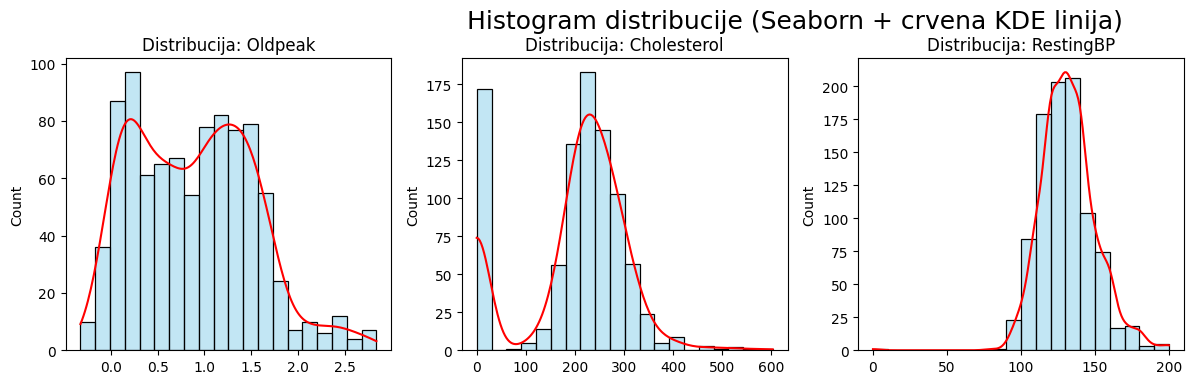

In [29]:
plot_numeric_distributions(df_reg, cols_to_bin)

# Outlier analysis

## IQR

In [32]:
noisy_cols = cols_to_bin + ['MaxHR']
df_iqr = df_encoded.copy()

for col in noisy_cols:
    Q1 = df_iqr[col].quantile(0.25)
    Q3 = df_iqr[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    df_iqr = df_iqr[(df_iqr[col] >= lower_bound) & (df_iqr[col] <= upper_bound)]


In [33]:
ref_dict['IQR']= TrainAndReturnSpecs(df_iqr)

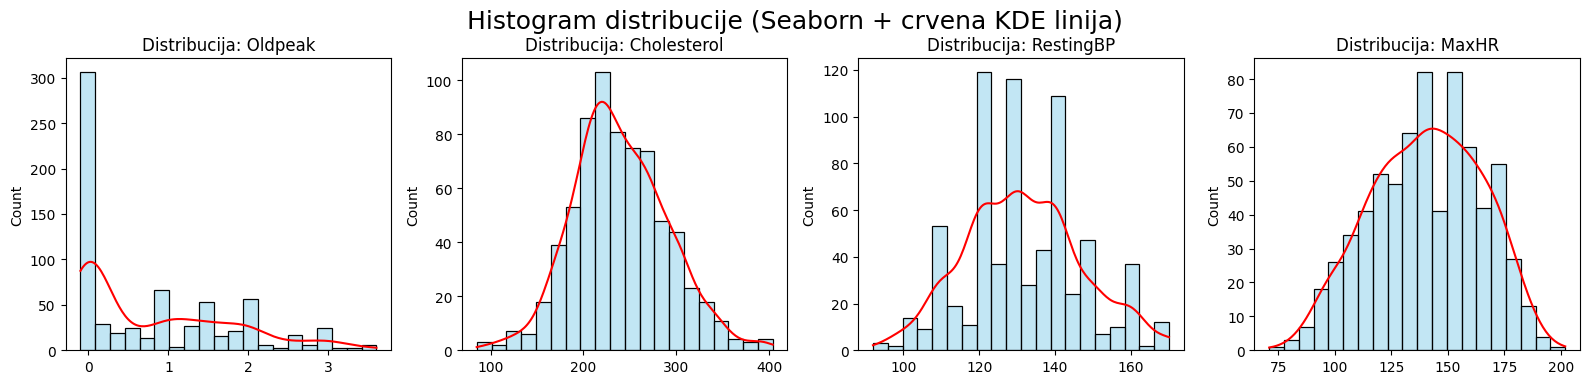

In [34]:
plot_numeric_distributions(df_iqr, noisy_cols)

## LocalOutlierFactor

In [36]:
df_locoutfac = df_encoded.copy()

X_values = df_locoutfac[noisy_cols].copy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_values)

lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
y_pred = lof.fit_predict(X_scaled)

df_locoutfac = df_locoutfac.iloc[y_pred != -1].copy()

X_scaled_clean = X_scaled[y_pred != -1]
df_locoutfac[noisy_cols] = scaler.inverse_transform(X_scaled_clean)

In [37]:
ref_dict['LocalOutlierFactor']= TrainAndReturnSpecs(df_locoutfac)

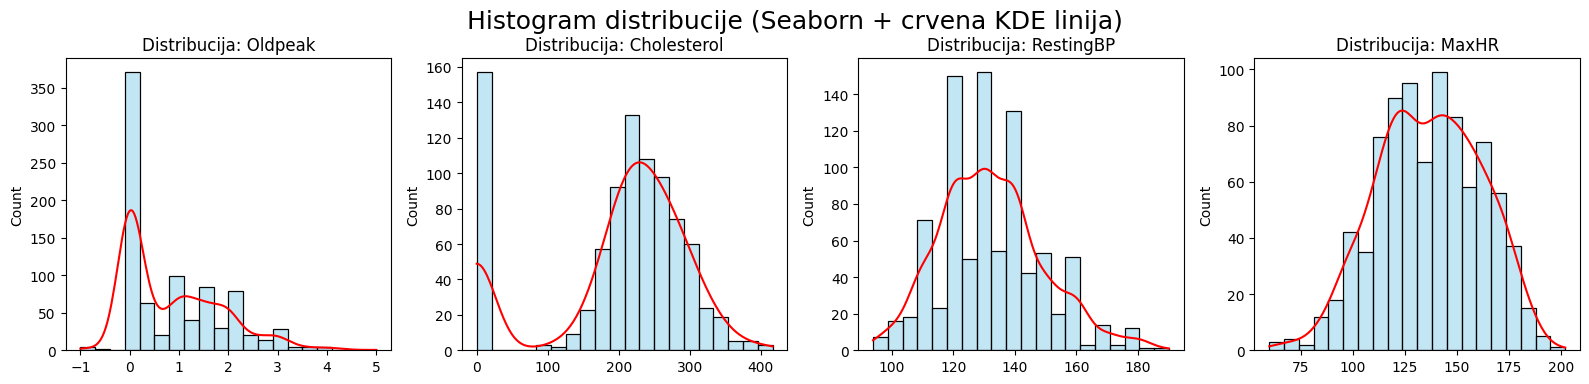

In [38]:
plot_numeric_distributions(df_locoutfac, noisy_cols)

## IsolationForest

In [40]:
df_iforest = df_encoded.copy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_iforest[noisy_cols])

iso_forest = IsolationForest(contamination=0.05, random_state=42)
y_pred = iso_forest.fit_predict(X_scaled)

mask = y_pred != -1

df_iforest = df_iforest.iloc[mask].copy()

X_scaled_clean = X_scaled[mask]
df_iforest[noisy_cols] = scaler.inverse_transform(X_scaled_clean)

In [41]:
ref_dict['IsolationForest']= TrainAndReturnSpecs(df_iforest)

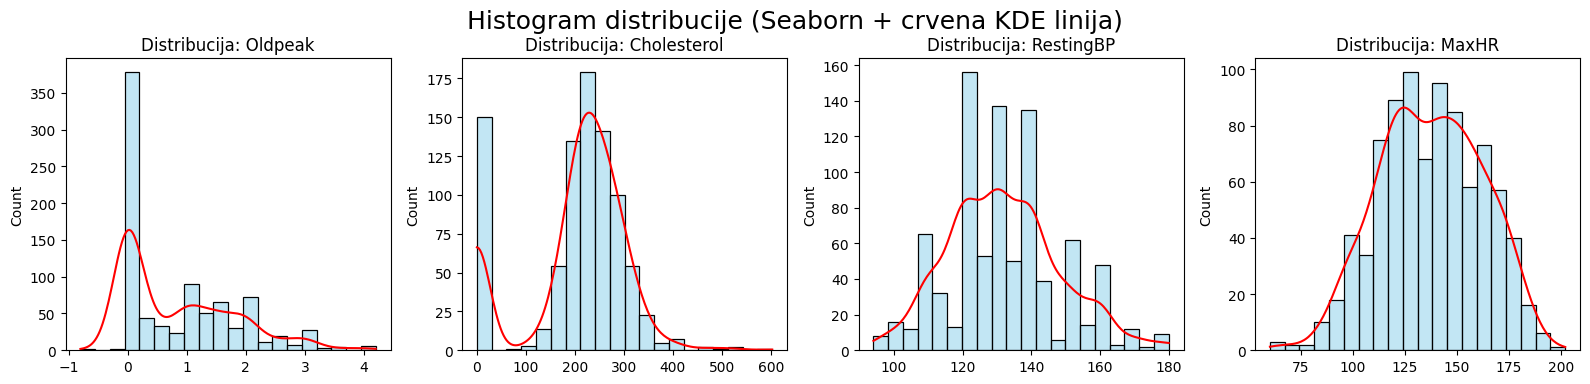

In [42]:
plot_numeric_distributions(df_iforest, noisy_cols)

## KMeans

In [44]:
df_kmeans = df_encoded.copy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_kmeans[noisy_cols])

kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X_scaled)

distances = np.linalg.norm(X_scaled - kmeans.cluster_centers_[kmeans.labels_], axis=1)

threshold = np.percentile(distances, 95)

mask = distances <= threshold

df_kmeans = df_kmeans.iloc[mask].copy()

X_scaled_clean = X_scaled[mask]
df_kmeans[noisy_cols] = scaler.inverse_transform(X_scaled_clean)

In [45]:
ref_dict['KMeans']= TrainAndReturnSpecs(df_kmeans)

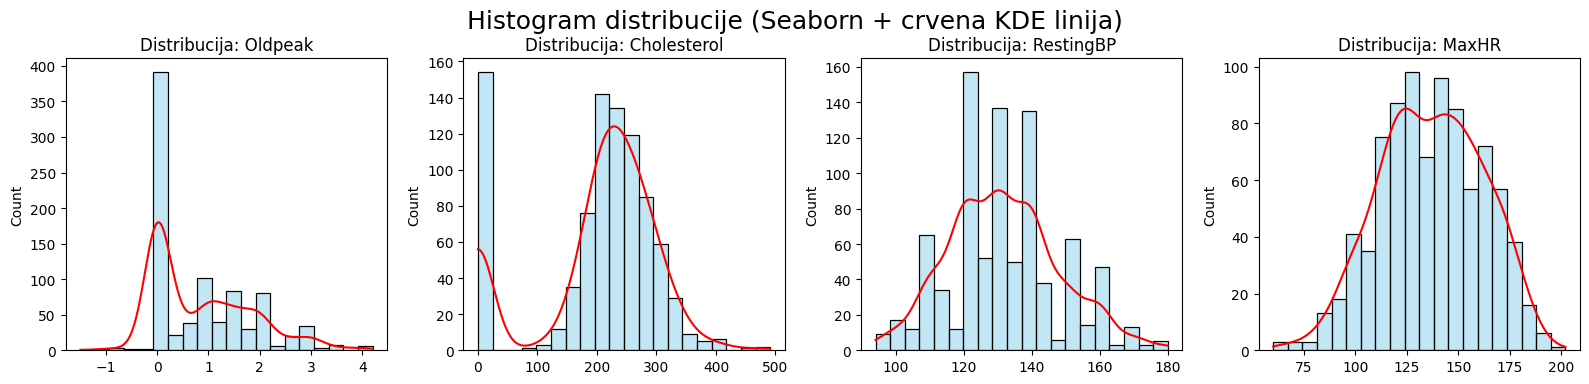

In [46]:
plot_numeric_distributions(df_kmeans, noisy_cols)

# Filters

## Ensemble

In [49]:
filter_algorithms = [
    RandomForestClassifier(n_estimators=50, random_state=42),
    GradientBoostingClassifier(random_state=42),
    make_pipeline(StandardScaler(),
                  LogisticRegression(solver="liblinear", max_iter=5000, random_state=42))
]

X = df_encoded.drop('HeartDisease', axis=1)
y = df_encoded['HeartDisease']

X_filtered = X.copy()
y_filtered = y.copy()

misclassified_counts = np.zeros(len(X_filtered))

for clf in filter_algorithms:
    clf.fit(X_filtered, y_filtered)
    y_pred = clf.predict(X_filtered)
    misclassified_counts += (y_pred != y_filtered)

threshold = len(filter_algorithms) // 2
mask = misclassified_counts <= threshold

X_clean = X_filtered[mask].copy()
y_clean = y_filtered[mask].copy()

X_clean = X_clean.reset_index(drop=True)
y_clean = y_clean.reset_index(drop=True)
df_ensembl = X_clean.copy()
df_ensembl['HeartDisease'] = y_clean

In [50]:
ref_dict['Ensemble']= TrainAndReturnSpecs(df_ensembl)

## CrossValidatedCommittees

In [52]:
X = df_encoded.drop('HeartDisease', axis=1)
y = df_encoded['HeartDisease']

X_filtered = X.copy()
y_filtered = y.copy()

misclassified_counts = np.zeros(len(X_filtered))

for clf in filter_algorithms:
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    y_pred = cross_val_predict(clf, X_filtered, y_filtered, cv=skf)
    misclassified_counts += (y_pred != y_filtered)

threshold = len(filter_algorithms) // 2  
mask = misclassified_counts <= threshold

X_clean = X_filtered[mask].copy()
y_clean = y_filtered[mask].copy()

X_clean = X_clean.reset_index(drop=True)
y_clean = y_clean.reset_index(drop=True)
df_crossval = X_clean.copy()
df_crossval['HeartDisease'] = y_clean

In [53]:
ref_dict['CrossValidatedCommittees']= TrainAndReturnSpecs(df_crossval)

## IterativePartitioning

In [55]:
def iterative_partitioning_filter(X, y, max_iter=10, gamma=5, p=0.01, y_fraction=0.05):
    # p: prag (% originalnog skupa) ispod koga se filter zaustavlja
    # y_fraction: procenat "dobrih" instanci koji se uklanja u svakoj iteraciji
    
    X, y = np.array(X), np.array(y)
    n = len(y)
    DT = np.arange(n)  # indeksi preostalih instanci
    
    for iteration in range(max_iter):
        print(f"\n=== Iteracija {iteration+1} ===")
        
        kf = KFold(n_splits=gamma, shuffle=True, random_state=iteration)
        preds = np.zeros((len(DT), gamma), dtype=object)
        
        for i, (train_idx, val_idx) in enumerate(kf.split(DT)):
            train_ids, val_ids = DT[train_idx], DT[val_idx]
            clf = DecisionTreeClassifier(random_state=iteration)
            clf.fit(X[train_ids], y[train_ids])
            preds[val_idx, i] = clf.predict(X[val_ids])
        
        maj_preds = [] # većinsko glasanje
        for i in range(len(DT)):
            votes, counts = np.unique(preds[i], return_counts=True)
            maj_preds.append(votes[np.argmax(counts)])
        maj_preds = np.array(maj_preds)
        
        noisy_idx = DT[maj_preds != y[DT]]
        good_idx = DT[maj_preds == y[DT]]
        
        print(f"Detektovano šumnih instanci: {len(noisy_idx)}")
     
        if len(noisy_idx) < p * n:
            print("Zaustavljam - broj šumnih ispod praga.")
            break
        
        n_good_remove = int(len(DT) * y_fraction) 
        if n_good_remove > 0:
            good_remove = np.random.choice(good_idx, size=n_good_remove, replace=False)
        else:
            good_remove = np.array([])
       
        remove_idx = np.concatenate([noisy_idx, good_remove])
        DT = np.setdiff1d(DT, remove_idx)  # DT ← DT \ {DN ∪ DG}
        print(f"Nakon uklanjanja ostalo: {len(DT)} instanci")
    
    return X[DT], y[DT]

In [56]:
X = df_encoded.drop('HeartDisease', axis=1)
y = df_encoded['HeartDisease']

max_iter = 10
gamma = 5          
p = 0.01           
y_fraction = 0.05  

X_clean, y_clean = iterative_partitioning_filter(X, y, max_iter=max_iter, gamma=gamma, p=p, y_fraction=y_fraction)

X_clean = pd.DataFrame(X_clean, columns=X.columns).reset_index(drop=True)
y_clean = pd.Series(y_clean, name='HeartDisease').reset_index(drop=True)
df_ipf = pd.concat([X_clean, y_clean], axis=1)

print(f"\nOriginalni dataset: {len(df_encoded)} instanci")
print(f"Pročišćeni dataset: {len(df_ipf)} instanci")


=== Iteracija 1 ===
Detektovano šumnih instanci: 508
Nakon uklanjanja ostalo: 365 instanci

=== Iteracija 2 ===
Detektovano šumnih instanci: 0
Zaustavljam - broj šumnih ispod praga.

Originalni dataset: 918 instanci
Pročišćeni dataset: 365 instanci


In [57]:
ref_dict['IterativePartitioning']= TrainAndReturnSpecs(df_ipf)

# Duplicates

## Exact Duplicates

In [60]:
df_encoded.duplicated().sum()

0

## Near Duplicates

In [62]:
df_tmp = df.copy()

cat_cols = df_tmp.select_dtypes(include=["object"]).columns.tolist()
num_cols = df_tmp.select_dtypes(include=[np.number]).columns.tolist()

scaler = StandardScaler()
num_data = scaler.fit_transform(df_tmp[num_cols]) if num_cols else np.array([])

# 3️Kategorijske kolone → Hamming distance
cat_data = df_tmp[cat_cols].fillna("").astype(str).values if cat_cols else np.array([])

num_threshold = 0.5      # Euclidean distance u standardizovanoj skali
cat_threshold = 0.1      # <=10% kategorijskih kolona se razlikuje

to_drop = set()
n = len(df_tmp)

for i in range(n):
    for j in range(i+1, n):
        
        # Numeričke kolone
        flag_num = False
        if num_cols:
            dist = np.linalg.norm(num_data[i] - num_data[j])
            flag_num = dist < num_threshold

        # Kategorijske kolone
        flag_cat = False
        if cat_cols:
            diff = np.mean(cat_data[i] != cat_data[j])  # Hamming distance
            flag_cat = diff <= cat_threshold

        # Kombinacija: ukloni ako su blizu u obe dimenzije
        if flag_num and flag_cat:
            to_drop.add(j)
            
df_neardup = df_encoded.copy()
df_neardup = df_neardup.drop(index=list(to_drop)).reset_index(drop=True)

print("Broj uklonjenih redova:", len(to_drop))

Broj uklonjenih redova: 25


In [63]:
ref_dict['NearDuplicates']= TrainAndReturnSpecs(df_neardup)

# Dimension reduction

## Feature Selection - embedded

In [168]:
X = df_encoded.drop('HeartDisease', axis=1)
y = df_encoded['HeartDisease']

model = LogisticRegression(penalty='l1', solver='liblinear')  # L1 penal
model.fit(X.values, y)

selector = SelectFromModel(model, prefit=True)
X_selected = selector.transform(X.values)
selected_features = X.columns[selector.get_support()]

In [170]:
df_reduced = pd.concat([pd.DataFrame(X_selected, columns=selected_features), y.reset_index(drop=True)], axis=1)

In [172]:
ref_dict['DimensionReduction']= TrainAndReturnSpecs(df_reduced)

# Resume

In [174]:
df_results = pd.DataFrame(ref_dict).T  # transpose da su metode po redovima
df_results

,accuracy,precision,recall,f1,roc_auc
WithNoise,0.902174,0.896226,0.931373,0.913462,0.933166
Binning,0.907609,0.897196,0.941176,0.918660,0.934182
Regression,0.945652,0.942308,0.960784,0.951456,0.974534
IQR,0.865248,0.838235,0.876923,0.857143,0.921964
LocalOutlierFactor,0.874286,0.870000,0.906250,0.887755,0.923128
IsolationForest,0.851429,0.848485,0.884211,0.865979,0.923224
KMeans,0.868571,0.860000,0.905263,0.882051,0.926776
Ensemble,0.919075,0.896226,0.969388,0.931373,0.980884
CrossValidatedCommittees,0.981250,0.968421,1.000000,0.983957,0.999361
IterativePartitioning,1.000000,0.000000,0.000000,0.000000,0.000000


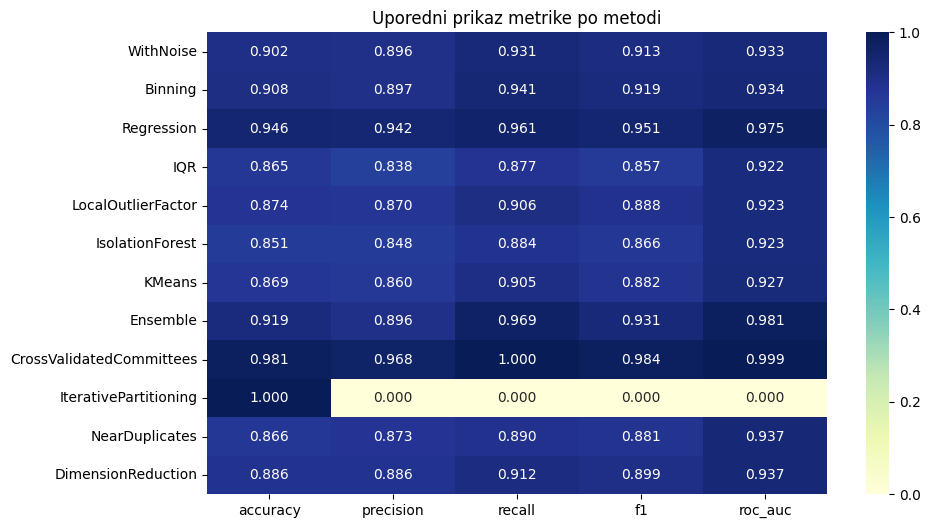

In [176]:
plt.figure(figsize=(10,6))
sns.heatmap(df_results, annot=True, cmap="YlGnBu", fmt=".3f")
plt.title("Uporedni prikaz metrike po metodi")
plt.show()

In [178]:
df_ranks = df_results.rank(ascending=False, method='min')  # veće je boljec
df_ranks['sum_rank'] = df_ranks.sum(axis=1)  # ukupan rank
df_ranks.sort_values('sum_rank')

,accuracy,precision,recall,f1,roc_auc,sum_rank
CrossValidatedCommittees,2.0,1.0,1.0,1.0,1.0,6.0
Regression,3.0,2.0,3.0,2.0,3.0,13.0
Ensemble,4.0,4.0,2.0,3.0,2.0,15.0
Binning,5.0,3.0,4.0,4.0,6.0,22.0
WithNoise,6.0,4.0,5.0,5.0,7.0,27.0
DimensionReduction,7.0,6.0,6.0,6.0,4.0,29.0
LocalOutlierFactor,8.0,8.0,7.0,7.0,10.0,40.0
NearDuplicates,10.0,7.0,9.0,9.0,5.0,40.0
KMeans,9.0,9.0,8.0,8.0,8.0,42.0
IterativePartitioning,1.0,12.0,12.0,12.0,12.0,49.0
